In [1]:
import Pkg
Pkg.activate(".")
Pkg.status()

  Activating project at `~/ascr_ad/compression_tests`


Status `~/ascr_ad/compression_tests/Project.toml`
  [c7e460c6] ArgParse v1.2.0
  [2685da08] BurgersEquation v0.1.0 `BurgersEquation`
  [336ed68f] CSV v0.10.15
  [d360d2e6] ChainRulesCore v1.25.1
  [523fee87] CodecBzip2 v0.8.5
  [5ba52731] CodecLz4 v0.4.6
  [ba30903b] CodecXz v0.7.4
  [944b1d66] CodecZlib v0.7.8
  [6b39b394] CodecZstd v0.8.6
  [a93c6f00] DataFrames v1.7.0
⌅ [f6369f11] ForwardDiff v0.10.38
  [e55a990b] HeatEquation v0.1.0 `../julia_cuda/HeatEquation`
  [e7cbb90b] ImplicitAD v0.3.1 `~/jdev/ImplicitAD`
  [d3d80556] LineSearches v7.3.0
  [429524aa] Optim v1.12.0
  [91a5bcdd] Plots v1.40.13
  [92933f4c] ProgressMeter v1.10.4
  [37e2e3b7] ReverseDiff v1.16.1 `~/jdev/ReverseDiff`
  [bd369af6] Tables v1.12.1
  [3bb67fe8] TranscodingStreams v0.11.3
Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated`


In [2]:
import ImplicitAD as IAD
import LinearAlgebra as LA
import ForwardDiff
import ForwardDiff as FD
import ReverseDiff
import ReverseDiff as RD

In [3]:
# import ChainRulesCore
import LineSearches
import Optim

In [4]:
using Plots

In [5]:
using BurgersEquation
import BurgersEquation as BE

In [6]:
# using Revise

In [7]:
# using ImplicitAD
# import ImplicitAD as IAD

# Parameters

In [8]:
Tf = tf = 1.0
Nx = 2^8
cfl = 0.85
x0 = [0.25, 1.0]
;

In [9]:
function make_gif(hist::BurgersEquation.BurgersHistory, N, gif_name; fps=20)

    # ani = @animate for ll in 1:length(optim_trace)
    #     make_plot_group(optim_trace, ll - 1, params, tol)
    # end

    x_grid = BurgersEquation.space_grid(N)

    umin = floor(minimum(hist.u[0]); digits=1)
    umax = ceil(maximum(hist.u[0]); digits=1)

    ani = @animate for k in sort(collect(keys(hist.t)))
        tu = hist.t[k]
        uk = hist.u[k]
        plot(x_grid, BE.expand_solution(uk), title="Time: $(tu)", legend=false, ylim=(umin,umax))
    end

    return gif(ani, gif_name * ".gif", fps=fps)

end

make_gif (generic function with 1 method)

# Burgers Solver Tests

In [10]:
function hat_initial_condition(x, hl, hr, hh, hb)
    hm = 0.5 * (hr + hl)
    if hl < x && x < hm
        v = (hh - hb) / (hm - hl) * (x - hl) + hb
    elseif hm <= x && x < hr
        v = (hb - hh) / (hr - hm) * (x - hr) + hb
    else
        v = hb*one(x)
    end
    return v
end

function set_initial_condition(ic, N)
    u0 = zeros(N)
    for i in 1:N
        xi = BurgersEquation.gridpoint(i, N)
        u0[i] = ic(xi)
    end
    return u0
end

set_initial_condition (generic function with 1 method)

In [11]:
# f(u) = 0.5*u^2
# fu(u) = u
# Tf = tf = 1.0

# # ratio = 0.35 # ratio = dt / dx
# Nx = 2^10
# @show Nx
# dx = BurgersEquation.gridsize(Nx)
# # dt = 5e-3

# # u0 = collect(range(1.0, 0.0, Nx))
# # u0 = zeros(Nx)
# # mp = Int(round(Nx/2))
# # u0[mp-100:mp+100] .= 1.0
# # u0 = hat_initial_condition(0.25, 0.75, 0.5, 0.2, Nx)
# # u0 = set_initial_condition(x->hat_initial_condition(x, 0.25, 0.75, 0.5, 0.2), Nx)
# u0 = set_initial_condition(x->1+0.2*sin(2*pi*x), Nx)
# # u0 = set_initial_condition(x->0.75 - (0.5 - x)^2, Nx)

# umax = maximum(u0)
# # cfl = umax * dt / dx
# # @show cfl
# cfl = 0.85
# # dt = cfl * dx / umax
# # @show dt
# # dt = 1.0 / ceil(Tf / dt)
# # @show dt
# dt = 1.0 / ceil(Tf * umax / (cfl * dx))
# @show dt
# cfl = umax * dt / dx
# @show cfl

# save_rate = max(Int(floor(2e-3 / dt)), 1)
# @show save_rate
# ;

f(u) = 0.5*u^2
fu(u) = u

@show Nx
dx = BurgersEquation.gridsize(Nx)
u0 = set_initial_condition(x->1+0.2*sin(2*pi*x), Nx)
# u0 = collect(BurgersEquation.space_grid(Nx)[1:Nx] .- 0.5)

umax = maximum(u0)
dt = 1.0 / ceil(Tf * umax / (cfl * dx))
@show dt
Nt = Tf / dt
@show Nt
cfl = umax * dt / dx
@show cfl

save_rate = max(Int(floor(2e-3 / dt)), 1)
@show save_rate
;

Nx = 256
dt = 0.0027624309392265192
Nt = 362.0
cfl = 0.8486187845303866
save_rate = 1


In [12]:
plf = BurgersEquation.setup(u0, f, fu, Tf, dt, Nx, :lf; save_rate=save_rate)
@time BurgersEquation.solve(plf)
plw = BurgersEquation.setup(u0, f, fu, Tf, dt, Nx, :lw; save_rate=save_rate)
@time BurgersEquation.solve(plw)

  0.936272 seconds (5.95 M allocations: 255.961 MiB, 13.45% gc time, 97.80% compilation time)
  0.044197 seconds (1.30 M allocations: 23.974 MiB, 75.96% compilation time)


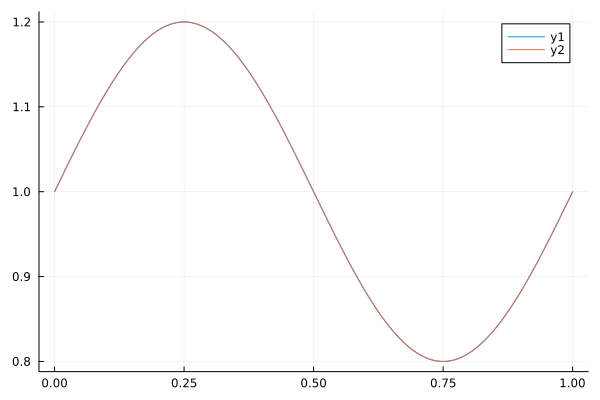

In [13]:
plot(BurgersEquation.space_grid(Nx), BurgersEquation.expand_solution(plf.u0))
plot!(BurgersEquation.space_grid(Nx), BurgersEquation.expand_solution(plw.u0))

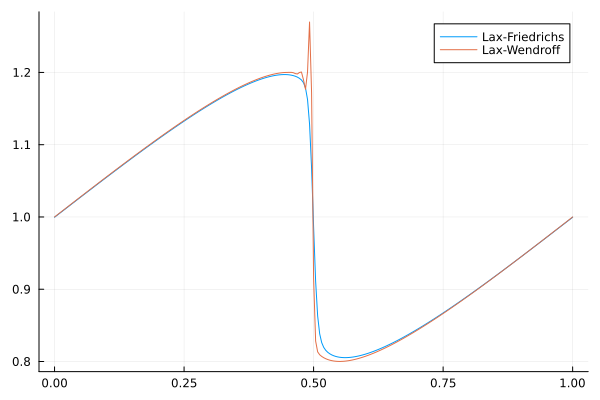

In [14]:
plot(BurgersEquation.space_grid(Nx), BurgersEquation.expand_solution(plf.uk), label="Lax-Friedrichs")
plot!(BurgersEquation.space_grid(Nx), BurgersEquation.expand_solution(plw.uk), label="Lax-Wendroff")

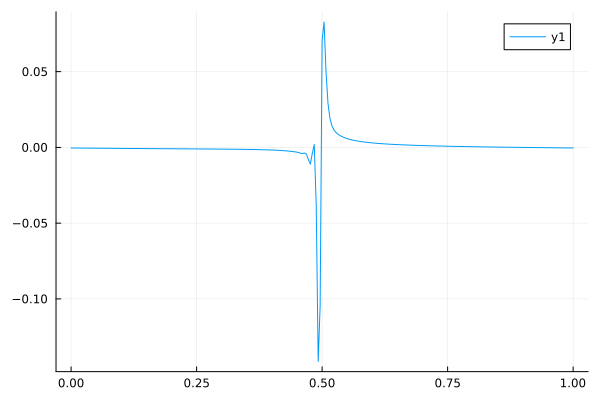

In [15]:
plot(BurgersEquation.space_grid(Nx), BurgersEquation.expand_solution(plf.uk - plw.uk))

In [16]:
# make_gif(plf.hist, Nx, "Lax-Friedrichs"; fps=20)

In [17]:
# make_gif(plw.hist, Nx, "Lax-Wendroff"; fps=20)

# Auto Differentiation

In [18]:
function implicit_burger_step(u0, params)

    prob = params[:prob]
    u1 = similar(u0)
    f = prob.f
    fprime = prob.fprime
    nflux = prob.num_flux
    dt = prob.dt
    dx = prob.dx
    Nx = prob.Nx
    
    BurgersEquation.burger_step(u0, u1, f, fprime, nflux, dt, dx, Nx)

    prob.uk .= u1
    
    return u1

end

function residual_burger_step(r, u1, u0, params)

    prob = params[:prob]
    f = prob.f
    fprime = prob.fprime
    flux = prob.num_flux
    dt = prob.dt
    Nt = prob.Nt
    dx = prob.dx
    Nx = prob.Nx
    ratio = dt / dx

     # Periodic boundary conditions
    Fp = flux(f, fprime, u0[1], u0[2], ratio)
    Fm = flux(f, fprime, u0[Nx], u0[1], ratio)
    r[1] = u1[1] - u0[1] + ratio * (Fp - Fm)

    Fp = flux(f, fprime, u0[Nx], u0[1], ratio)
    Fm = flux(f, fprime, u0[Nx-1], u0[Nx], ratio)
    r[Nx] = u1[Nx] - u0[Nx] + ratio * (Fp - Fm)

    for i in 2:Nx-1
        Fp = flux(f, fprime, u0[i], u0[i+1], ratio)
        Fm = flux(f, fprime, u0[i-1], u0[i], ratio)
        r[i] = u1[i] - u0[i] + ratio * (Fp - Fm)
    end

    return

end

# wrap residual function in a explicit form for convenience and ensure type of r is appropriate
function residual_wrap(yw, xw, pw) 
    T = promote_type(eltype(xw), eltype(yw))
    # match type of input variables
    rw = zeros(T, length(yw))
    residual_burger_step(rw, yw, xw, pw)
    return rw
end

function residual_jacobian_y(r, u1, u0, p)
    return LA.I
end

residual_jacobian_y (generic function with 1 method)

In [19]:
function my_burger_loop(
    prob::BurgersEquation.BurgersProblem, p;
    progress::Bool=false, mode::Symbol=:implicit
)

    prob.v .= prob.u0
    u0 = prob.v
    # u1 = prob.uk
    # f = prob.f
    # fprime = prob.fprime
    # nflux = prob.num_flux
    dt = prob.dt
    Nt = prob.Nt
    # dx = prob.dx
    # Nx = prob.Nx
    hist = prob.hist

    if progress
        pm = PM.Progress(Nt)
    end

    count = 0

    while count < Nt

        if mode == :direct
            u1 = implicit_burger_step(u0, p)
        elseif mode == :implicit
            u1 = IAD.implicit(implicit_burger_step, residual_burger_step, u0, p; drdy=residual_jacobian_y)
            prob.uk .= u1
        elseif mode == :svd
            u1 = IAD.implicit_svd(implicit_burger_step, residual_burger_step, u0, p; drdy=residual_jacobian_y)
            prob.uk .= u1
        else
            error("Unrecognized mode: $mode")
        end

        count += 1
        BurgersEquation.save_solution(hist, u1, count, count * dt)

        if progress
            PM.next!(pm)
        end

        # @show eltype(u0)
        # @show eltype(u1)

        u0 .= u1

    end

    if progress
        PM.finish!(pm)
    end

    return

end

function burger_solution(
    x, p; 
    save::Bool=false, progress::Bool=false, mode::Symbol=:normal
)
    
    f(u) = 0.5*u^2
    fu(u) = u

    u0 = initial_condition(x, p)
    # @show eltype(u0)
    Nx = p[:Nx]
    cfl = p[:cfl]
    Tf = p[:tf]
    # Assumes u >= 0
    umax = maximum(u0)
    dx = BurgersEquation.gridsize(Nx)
    # dt = cfl * dx / umax
    # dt = 1.0 / ceil(Tf / dt)
    dt = 1.0 / ceil(Tf * umax / (cfl * dx))

    save_rate = save ? max(1, Int(floor(2e-3 / dt))) : -1
    cfl = dt * umax / dx

    if p[:mode] == :svd
        tol = get(p, :tol, 0.0)
        nsv = get(p, :nsv, 3)
        println("SVD Mode -- " * ( tol > 0.0 ? "tol: $tol" : "nsv: $nsv"))
    end

    bp = BurgersEquation.setup(u0, f, fu, p[:tf], dt, Nx, p[:flux]; save_rate=save_rate)
    p[:prob] = bp
    if mode == :normal
        BurgersEquation.solve(bp; progress=progress)
    else
        my_burger_loop(bp, p; progress=progress, mode=mode)
    end
    
    return bp

end

burger_solution (generic function with 1 method)

In [20]:
function ic_smooth(x, a, b)
    return b + a*sin(2*pi*x)
end

function ic_hat(x, a, b)
    return hat_initial_condition(x, 0.0, 1.0, b, a)
end

function initial_condition(x, p)

    Nx = p[:Nx]
    ic = p[:ic]
    u0 = zeros(eltype(x), Nx)

    for i in 1:Nx
        xi = BurgersEquation.gridpoint(i, Nx)
        u0[i] = ic(xi, x...)
    end

    return u0

end

function cost_u(x, p)

    bp = burger_solution(x, p; save=false, mode=p[:mode])

    # umax = maximum(bp.uk)
    # umin = minimum(bp.uk)
    # return umin - umax

    return (bp.uk[end] - 1.0)^2

end

function cost_x(x, p)
    return 0.5*LA.norm(x, 2)^2
end

function cost(x, p)
    a = 1.0
    b = 1.0
    return a*cost_x(x,p) + b*cost_u(x, p)
end

cost (generic function with 1 method)

## Functional Tests

In [21]:
# x0 = [0.25, 1.0]

my_params = Dict(
    :mode => :normal,
    :Nx => Nx,
    :cfl => cfl,
    :tf => tf,
    :flux => :lf,
    :ic => ic_smooth,
    # :ic => ic_hat,
)

direct_params = copy(my_params)
direct_params[:mode] = :direct

implicit_params = copy(my_params)
implicit_params[:mode] = :implicit

k = log2(Nx)
m = 2^Int(ceil(k/2))
n = 2^Int(floor(k/2))
@show (m,n)

svd_params = copy(my_params)
svd_params[:forward_svd] = true
svd_params[:mode] = :svd
# svd_params[:nsv] = 8
svd_params[:tol] = 1e-5
svd_params[:matdim] = (m,n)

my_params

(m, n) = (16, 16)


Dict{Symbol, Any} with 6 entries:
  :Nx   => 256
  :mode => :normal
  :flux => :lf
  :ic   => ic_smooth
  :cfl  => 0.848619
  :tf   => 1.0

In [22]:
cost(x0, my_params)

0.5312576696309138

In [23]:
cost(x0, direct_params)

0.5312576696309138

In [24]:
cost(x0, implicit_params)

0.5312576696309138

In [25]:
cost(x0, svd_params)

SVD Mode -- tol: 1.0e-5


0.5312576696309138

In [26]:
@time FD.gradient(x->cost(x, my_params), x0)

  0.764823 seconds (5.63 M allocations: 253.863 MiB, 3.69% gc time, 96.91% compilation time)


2-element Vector{Float64}:
 0.25002977767876816
 0.9978356227644964

In [27]:
@time FD.gradient(x->cost(x, direct_params), x0)

  0.980580 seconds (8.71 M allocations: 413.182 MiB, 4.52% gc time, 98.44% compilation time)


2-element Vector{Float64}:
 0.25002977767876816
 0.9978356227644964

In [28]:
@time FD.gradient(x->cost(x, implicit_params), x0)

  1.047003 seconds (9.07 M allocations: 358.782 MiB, 4.28% gc time, 64.77% compilation time)


2-element Vector{Float64}:
 0.25002977767876816
 0.9978356227644964

In [29]:
@time FD.gradient(x->cost(x, svd_params), x0)

SVD Mode -- tol: 1.0e-5
  1.212580 seconds (10.59 M allocations: 443.507 MiB, 3.51% gc time, 68.53% compilation time)


2-element Vector{Float64}:
 0.25002978041838303
 0.9978354407325081

In [30]:
# @time RD.gradient(x->cost(x, my_params), x0)

In [31]:
# @time RD.gradient(x->cost(x, direct_params), x0)

In [32]:
# @time RD.gradient(x->cost(x, implicit_params), x0)

In [33]:
# @time RD.gradient(x->cost(x, svd_params), x0)

In [34]:
cx_svd = FD.gradient(x->cost(x, svd_params), x0)
cx_fd = FD.gradient(x->cost(x, my_params), x0)
@show LA.norm(cx_svd - cx_fd, Inf)
@show LA.norm(cx_svd - cx_fd, 2)

SVD Mode -- tol: 1.0e-5
LA.norm(cx_svd - cx_fd, Inf) = 1.820319883716337e-7
LA.norm(cx_svd - cx_fd, 2) = 1.820526030578997e-7


1.820526030578997e-7

## Residual Test

In [35]:
# # f(u) = 0.5*u^2
# # fu(u) = u

# Nx = 2^6
# @show Nx
# dx = BurgersEquation.gridsize(Nx)

# # u0 = set_initial_condition(x->hat_initial_condition(x, 0.25, 0.75, 0.5, 0.2), Nx)
# u0 = set_initial_condition(x->1+0.2*sin(2*pi*x), Nx)
# umax = maximum(u0)
# tf = cfl * dx / umax
# dt = tf
# @show dt

# # r = zeros(Nx)
# rtest = BurgersEquation.setup(u0, f, fu, tf, dt, Nx, :lf; save_rate=-1)
# @show rtest.Nt
# BurgersEquation.solve(rtest)
# r = residual_wrap(rtest.uk, rtest.u0, Dict(:prob => rtest))
# @show LA.norm(r, Inf)
# ;

# SVD Compression

In [36]:
function vector_svd(u, m, n)
    @assert(length(u) == m*n)
    return LA.svd(reshape(u, m, n))
end

function vector_svd_sweep(u::AbstractVector)
    N = length(u)
    rd = Dict()
    for m in 1:Int(ceil(sqrt(N)))
    # for m in 1:N
        (n, r) = divrem(N, m)
        if r == 0
            rd[(m,n)] = vector_svd(u, m, n)
        end
    end
    return rd
end

function plot_svd_sweep_results(svds::Dict)
    p = plot(yscale=:log10, yticks=[10.0^k for k in -20:1:4], dpi=300, xlabel="Index", ylabel="Singular Value")
    # for ((m,n),svd) in pairs(svds)
    for (m,n) in sort(collect(keys(svds)))
        svd = svds[(m,n)]
        scatter!(p, svd.S, label="($m,$n)")
    end
    return p
end

plot_svd_sweep_results (generic function with 1 method)

## Hat IC

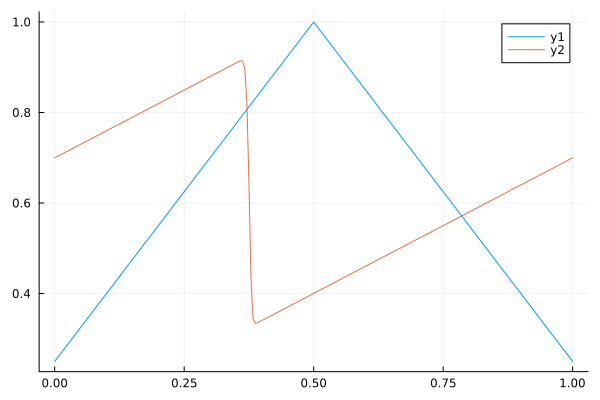

In [37]:
my_params[:ic] = ic_hat
bp = burger_solution(x0, my_params; save=true)
plot(BurgersEquation.space_grid(Nx), BurgersEquation.expand_solution(bp.u0))
plot!(BurgersEquation.space_grid(Nx), BurgersEquation.expand_solution(bp.uk))

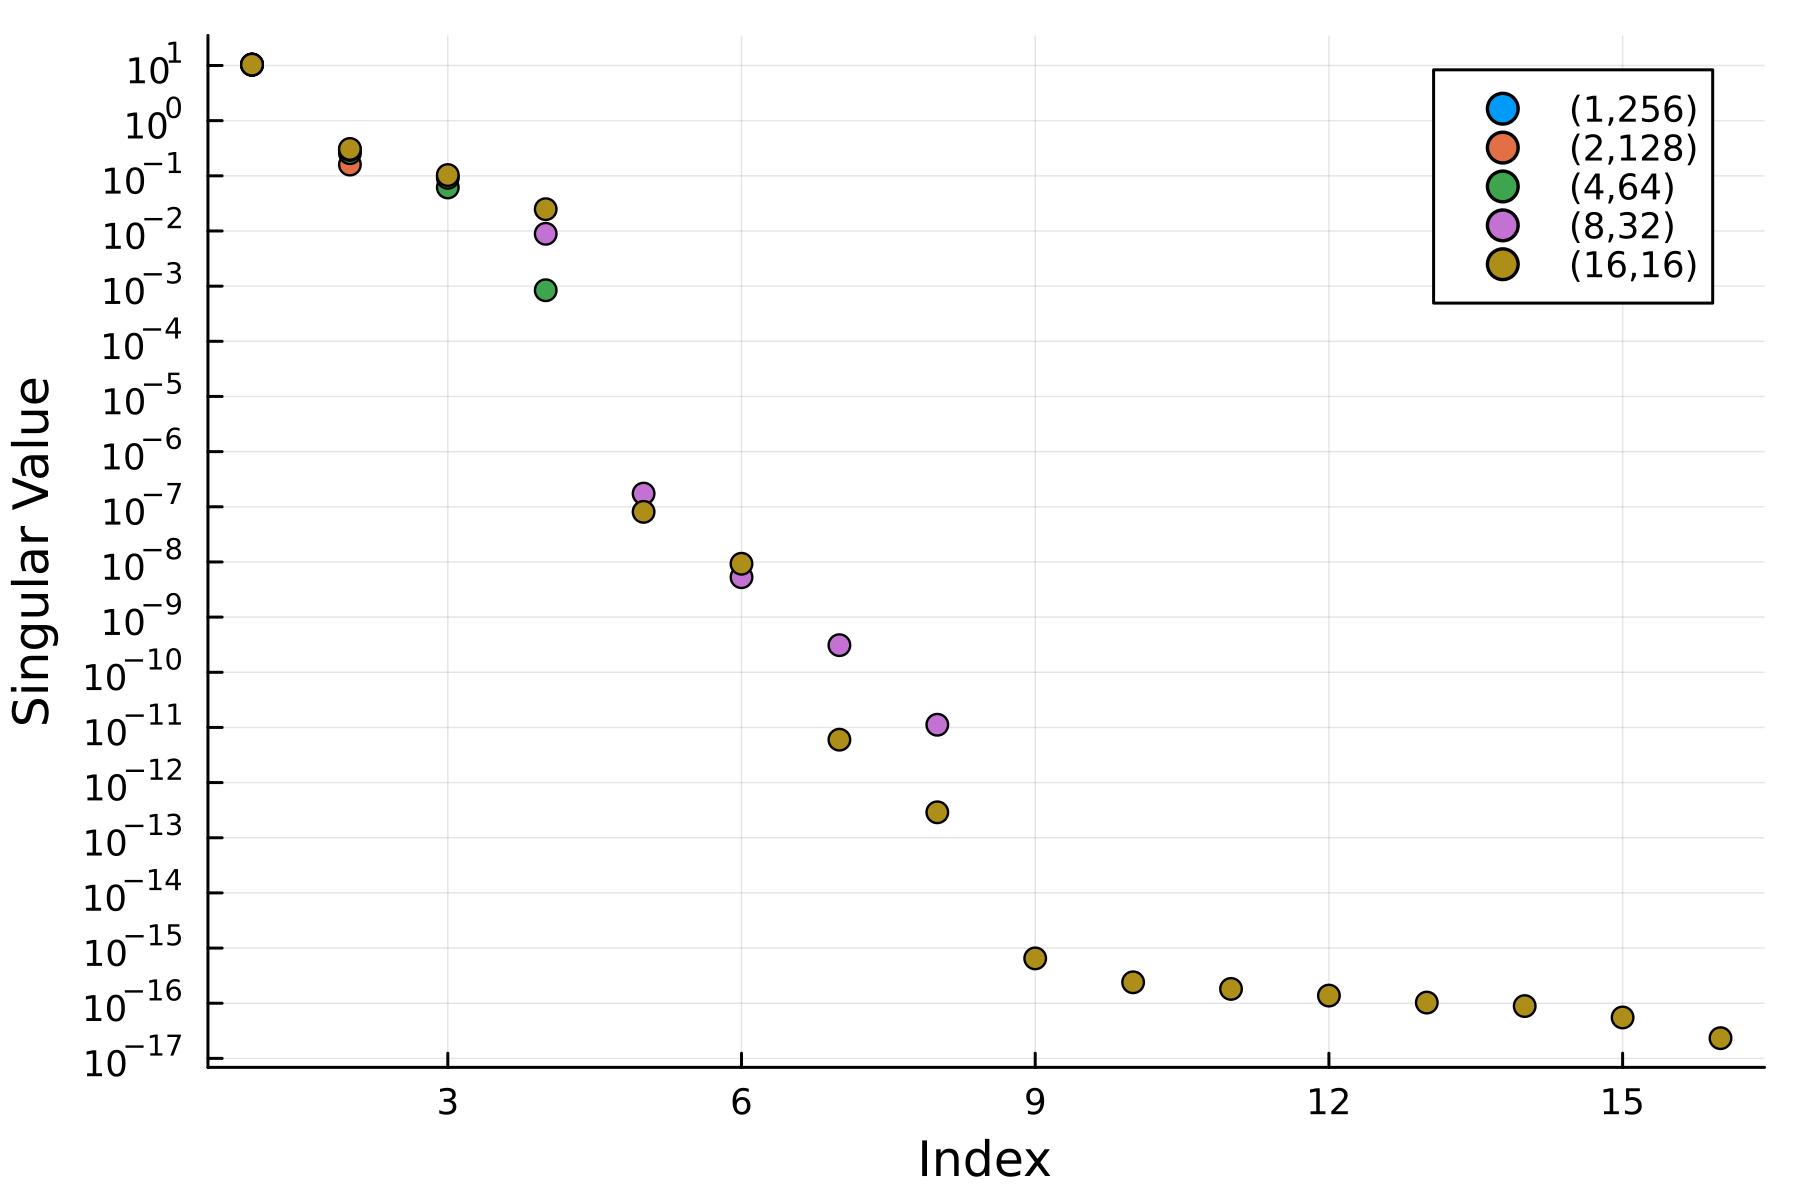

In [38]:
u_sol = bp.uk
svds = vector_svd_sweep(u_sol)
plot_svd_sweep_results(svds)

## Smooth IC

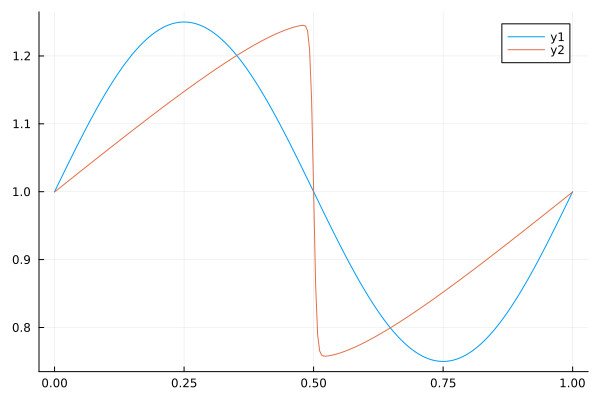

In [39]:
my_params[:ic] = ic_smooth
bp = burger_solution(x0, my_params; save=true)
plot(BurgersEquation.space_grid(Nx), BurgersEquation.expand_solution(bp.u0))
plot!(BurgersEquation.space_grid(Nx), BurgersEquation.expand_solution(bp.uk))

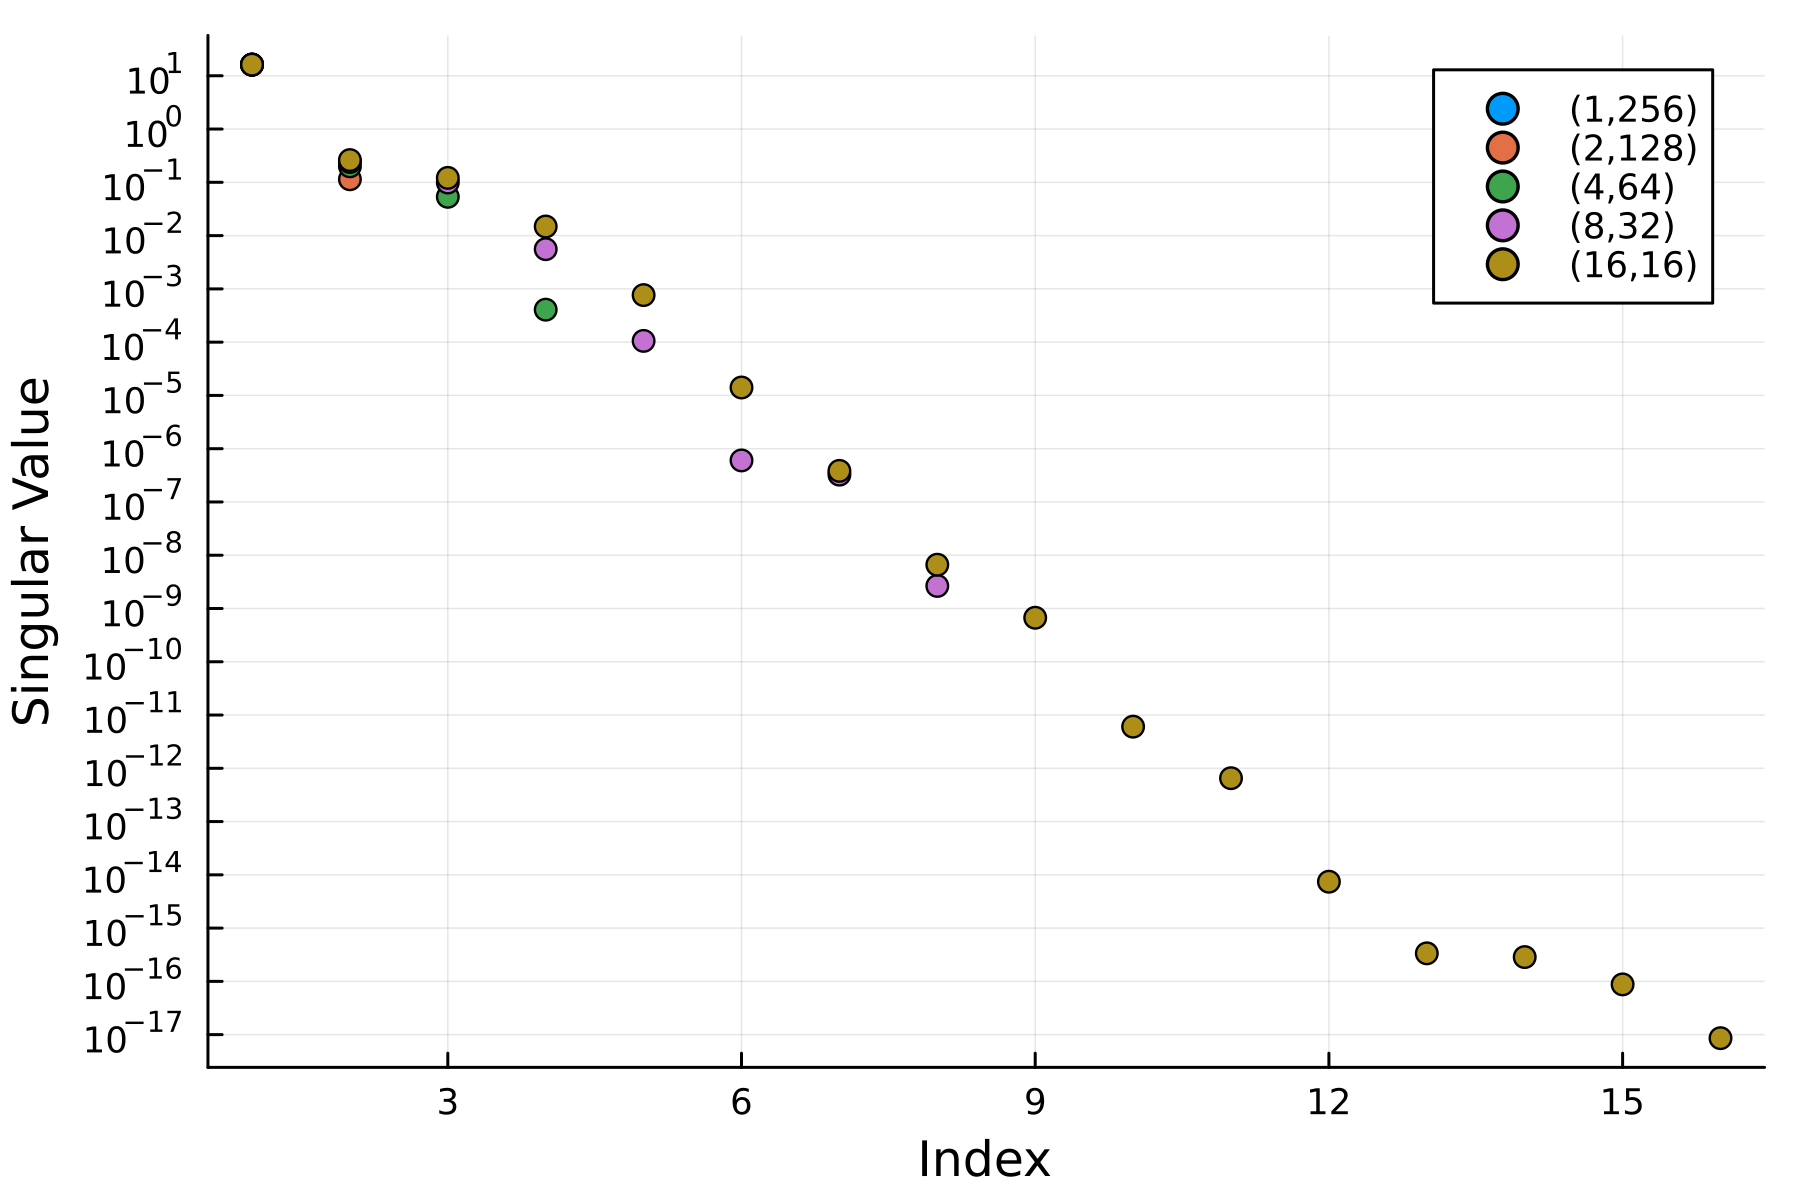

In [40]:
u_sol = bp.uk
svds = vector_svd_sweep(u_sol)
plot_svd_sweep_results(svds)

In [41]:
for (m,n) in sort(collect(keys(svds)))
    svd = svds[(m,n)]
    @show (m,n)
    @show svd.S
end

(m, n) = (1, 256)
svd.S = [16.19734315483975]
(m, n) = (2, 128)
svd.S = [16.19694076480441, 0.11417152469453881]
(m, n) = (4, 64)
svd.S = [16.196020413584304, 0.19997239625426225, 0.05346880908351968, 0.00040692278765851414]
(m, n) = (8, 32)
svd.S = [16.195258079920286, 0.24015270646068612, 0.09918035450996028, 0.005560947068435547, 0.0001055320658797287, 6.01570831281503e-7, 3.2536868204892504e-7, 2.6490977692552563e-9]
(m, n) = (16, 16)
svd.S = [16.194764729789387, 0.2619232292189344, 0.12123024350751083, 0.014815117305226878, 0.0007645649700226777, 1.4068612833618738e-5, 3.8318590546615516e-7, 6.632370317694273e-9, 6.697279131336044e-10, 6.047914509351064e-12, 6.516903560598111e-13, 7.425523316722563e-15, 3.3577370847551827e-16, 2.8578064927217194e-16, 8.772316643701932e-17, 8.579498893676512e-18]


## Memory Usage

In [42]:
function svd_dimensions(ngrid)
    k = log2(ngrid)
    m = 2^Int(ceil(k/2))
    n = 2^Int(floor(k/2))
    return (m,n)
end

function svd_mem(nsv, ngrid)
    # m = Int(sqrt(ngrid))
    # return nsv + 2*nsv*m
    (m,n) = svd_dimensions(ngrid)
    return nsv * (m + n + 1)
end

function svd_mem_sweep(ngrid)
    # m = Int(sqrt(ngrid))
    (m,n) = svd_dimensions(ngrid)
    nsvs = 1:min(m,n)
    mem_svd = zeros(Int, min(m,n))
    for nsv in nsvs
        mem_svd[nsv] = svd_mem(nsv, ngrid)
    end
    return (nsvs, mem_svd)
end

function svd_mem_savings()
    mem_savings = Dict{Int, Any}()
    for k in 2:14
        Nx = 2^k
        (nsvs, mem_svd) = svd_mem_sweep(Nx)
        saving = Nx * 8 / 1024 .- mem_svd * 8 / 1024
        mem_savings[Nx] = (nsvs, saving)
    end
    return mem_savings
end

function plot_savings(mem_save)
    p = plot(
        # xscale=:log10,
        ylabel="kB",
        xlabel="Number Singular Values",
        title="SVD compression vs standard (per step)",
    )
    for Nx in sort(collect(keys(mem_save)))
        (nsvs, save) = mem_save[Nx]
        plot!(p, nsvs, save, label=string(Nx))
    end
    return p
end

plot_savings (generic function with 1 method)

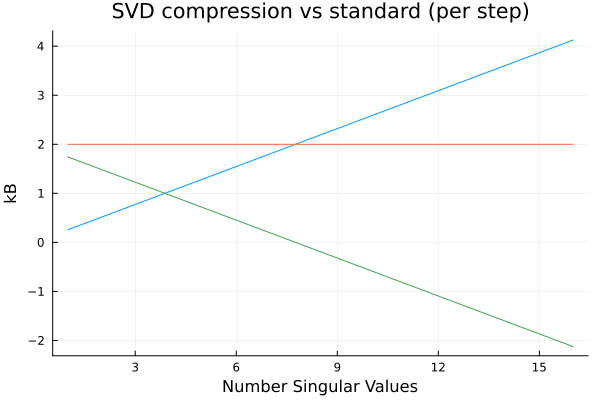

In [43]:
(num_svs, mem_svd) = svd_mem_sweep(Nx)
p = plot(num_svs, mem_svd * 8 / 1024,
    legend=false,
    ylabel="kB",
    xlabel="Number Singular Values",
    title="SVD compression vs standard (per step)",
)
plot!(p, num_svs, fill(Nx * 8 / 1024, length(num_svs)))
plot!(p, num_svs, fill(Nx * 8 / 1024, length(num_svs)) - mem_svd * 8 / 1024, label="Savings")

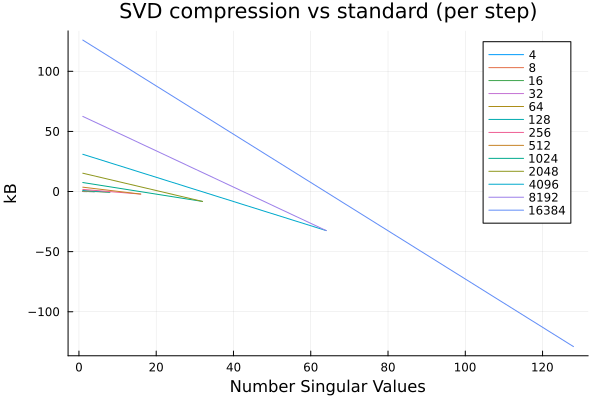

In [44]:
mr = svd_mem_savings()
plot_savings(mr)

## Effect on Solution

SVD Mode -- tol: 1.0e-5


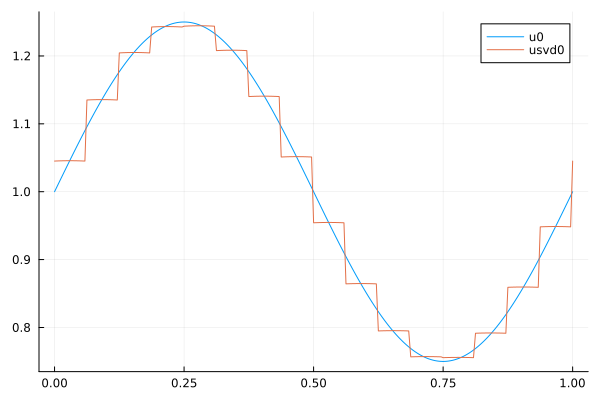

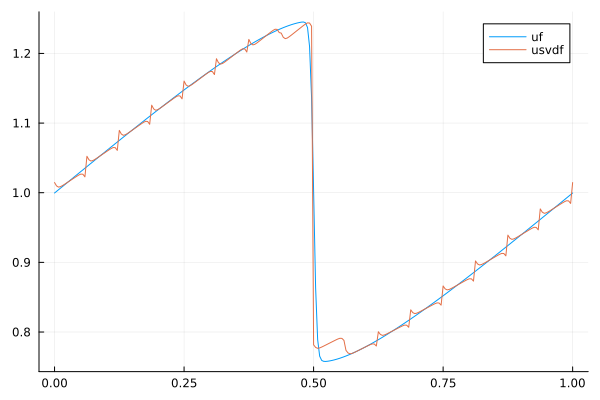

In [45]:
x0 = [0.25, 1.0]
bp = burger_solution(x0, svd_params; save=true)
u0 = bp.u0
uf = bp.uk
usvd0 = IAD.SVDVector(u0, m, n, 1)
usvdf = IAD.SVDVector(uf, m, n, 1)
p = plot(BurgersEquation.space_grid(svd_params[:Nx]), BurgersEquation.expand_solution(u0), label="u0")
plot!(p, BurgersEquation.space_grid(svd_params[:Nx]), BurgersEquation.expand_solution(usvd0), label="usvd0")
display(p)
p = plot(BurgersEquation.space_grid(svd_params[:Nx]), BurgersEquation.expand_solution(uf), label="uf")
plot!(p, BurgersEquation.space_grid(svd_params[:Nx]), BurgersEquation.expand_solution(usvdf), label="usvdf")
display(p)
;

In [46]:
function svd_solution_residual_sweep(x0, params)

    bp = burger_solution(x0, params)
    uf = bp.uk
    
    ngrid = params[:Nx]
    # m = Int(sqrt(ngrid))
    (m,n) = svd_dimensions(ngrid)
    res = zeros(min(m,n))
    nsvs = 1:min(m,n)
    
    for nsv in nsvs
        usvdf = IAD.SVDVector(uf, m, n, nsv)
        res[nsv] = LA.norm(uf - usvdf)
    end
    
    return (nsvs, res)
end

function svd_solution_residual_grid_size_sweep(x0)
    the_params = Dict(
        :mode => :normal,
        :cfl => cfl,
        :tf => tf,
        :flux => :lf,
        :ic => ic_smooth,
    )
    results = Dict{Int,Any}()
    for k in 2:14
        Nx = 2^k
        the_params[:Nx] = Nx
        (nsvs, res) = svd_solution_residual_sweep(x0, the_params)
        results[Nx] = (nsvs, res)
    end
    return results
end

function plot_svd_residuals(results::Dict)
    p = plot(yscale=:log10, ylabel="L2 Residual", xlabel="Number of Singular Values")
    # for (Nx, (nsvs, res)) in pairs(results)
    for Nx in sort(collect(keys(results)))
        (nsvs, res) = results[Nx]
        scatter!(p, nsvs, res, label=string(Nx))
    end
    return p
end

plot_svd_residuals (generic function with 1 method)

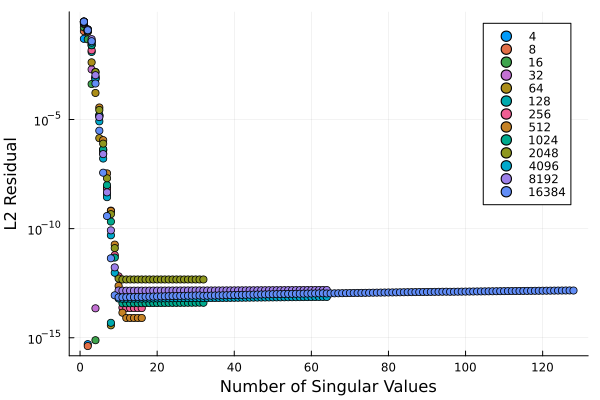

In [47]:
x0 = [0.25, 1.0]
# nsvs, residuals = svd_solution_residual_sweep(x0, my_params)
# plot(nsvs, residuals, yscale=:log10, ylabel="L2 Residual", xlabel="Number of Singular Values")
rd = svd_solution_residual_grid_size_sweep(x0)
plot_svd_residuals(rd)

# Optimization

In [48]:
tol = 1e-4
my_options = Optim.Options(
    g_abstol=tol,
    # g_reltol=tol,
    outer_g_abstol=tol,
    # outer_g_reltol=tol,
    store_trace=true,
    extended_trace=true,
    show_trace=true
)
# lb = [-1.0, -1.0, 0.0, 0.0]
# ub = [1.0, 1.0, Inf, Inf]
lb = [0.0, -Inf]
ub = [Inf, Inf]
my_params = Dict(
    :Nx => Nx,
    :cfl => cfl,
    :tf => tf,
    :flux => :lf,
    :ic => ic_smooth,
    :mode => :direct,
)
@show my_params
@show x0
rvs_params = copy(my_params)
rvs_params[:mode] = :implicit
svd_params = copy(my_params)
svd_params[:mode] = :svd
# svd_params[:nsv] = 8
svd_params[:tol] = 1e-5
svd_params[:forward_svd] = true
svd_params[:matdim] = (m,n)
;

my_params = Dict{Symbol, Any}(:Nx => 256, :flux => :lf, :ic => Main.ic_smooth, :mode => :direct, :cfl => 0.8486187845303866, :tf => 1.0)
x0 = [0.25, 1.0]


## ForwardDiff

In [49]:
my_objective(x) = cost(x, my_params)

@time res = Optim.optimize(
    my_objective,
    lb,
    ub,
    x0,
    # Optim.Fminbox(Optim.BFGS(linesearch=LineSearches.BackTracking(order=3))),
    Optim.Fminbox(Optim.BFGS()),
    my_options;
    autodiff = :forward, # uses ForwardDiff.jl
)
@show Optim.converged(res)
@show Optim.minimum(res)
;

Fminbox
-------
Initial mu = 0.000311966

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.000311966

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     5.316901e-01     9.982681e-01
 * Current step size: 1.0
 * time: 0.011209964752197266
 * g(x): [0.25046225487078594, 0.9982680999565142]
 * ~inv(H): [1.0 0.0; 0.0 1.0]
 * x: [0.25, 1.0]
     1     3.600213e-01     7.317452e-01
 * Current step size: 0.18626205236704166
 * time: 0.6484110355377197
 * g(x): [0.1616779875677021, 0.7317451681339199]
 * ~inv(H): [0.9458268351437082 -0.14003646390158417; -0.1400364639015842 0.7442980556949114]
 * x: [0.20334838636729033, 0.8140605348895525]
     2     2.436729e-01     4.840172e-01
 * Current step size: 0.5058449975340129
 * time: 0.6711969375610352
 * g(x): [-0.4840172305716279, -0.12633799478204888]
 * ~inv(H): [0.8541740558898608 -0.6130140628854519; -0.613014062885452 0.7690037367322933]
 * x: [0.17782932901324766, 0.

In [50]:
res

 * Status: success

 * Candidate solution
    Final objective value:     2.172656e-01

 * Found with
    Algorithm:     Fminbox with BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 4.30e-04 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.98e-03 ≰ 0.0e+00
    |g(x)|                 = 4.93e-01 ≰ 1.0e-04

 * Work counters
    Seconds run:   3  (vs limit Inf)
    Iterations:    2
    f(x) calls:    197
    ∇f(x) calls:   197


In [51]:
@show Optim.converged(res)
@show Optim.minimum(res)
@show Optim.minimizer(res)
x_fwd = Optim.minimizer(res)
;

Optim.converged(res) = true
Optim.minimum(res) = 0.21726560006949971
Optim.minimizer(res) = [0.2847717148748076, 0.5074934784953581]


## ReverseDiff

In [52]:
# rvs_objective(x) = cost(x, rvs_params)
# function rvs_gradient(g, x)
#     g .= RD.gradient(rvs_objective, x)
#     return
# end

# @time res = Optim.optimize(
#     rvs_objective,
#     rvs_gradient,
#     lb,
#     ub,
#     x0,
#     Optim.Fminbox(Optim.BFGS()),
#     my_options;
#     # autodiff = :forward, # uses ForwardDiff.jl
# )
# @show Optim.converged(res)
# @show Optim.minimum(res)
# ;

In [53]:
# @show Optim.converged(res)
# @show Optim.minimum(res)
# @show Optim.minimizer(res)
# x_rvs = Optim.minimizer(res)
# ;

## Finite Differences

In [54]:
# my_objective(x) = cost(x, my_params)

# @time res = Optim.optimize(
#     my_objective,
#     lb,
#     ub,
#     x0,
#     Optim.Fminbox(Optim.BFGS()),
#     my_options
# )
# @show Optim.converged(res)
# @show Optim.minimum(res)
# ;

In [55]:
# @show Optim.converged(res)
# @show Optim.minimum(res)
# @show Optim.minimizer(res)
# x_fnt = Optim.minimizer(res)
# ;

## SVD Reverse

Currently using ForwardDiff in an equivalent way because it is faster

In [56]:
svd_objective(x) = cost(x, svd_params)
function svd_gradient(g, x)
    RD.gradient!(g, svd_objective, x)
    return
end

@time res = Optim.optimize(
    svd_objective,
    # svd_gradient,
    lb,
    ub,
    x0,
    Optim.Fminbox(Optim.BFGS()),
    my_options;
    autodiff = :forward, # uses ForwardDiff.jl
)
@show Optim.converged(res)
@show Optim.minimum(res)
;

SVD Mode -- tol: 1.0e-5
Fminbox
-------
Initial mu = 0.000311966

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.000311966

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     5.316901e-01     9.982679e-01
 * Current step size: 1.0
 * time: 1.811981201171875e-5
 * g(x): [0.2504622575482628, 0.9982679178623879]
 * ~inv(H): [1.0 0.0; 0.0 1.0]
 * x: [0.25, 1.0]
SVD Mode -- tol: 1.0e-5
SVD Mode -- tol: 1.0e-5
SVD Mode -- tol: 1.0e-5
     1     3.600212e-01     7.317450e-01
 * Current step size: 0.18626226698199455
 * time: 0.8325800895690918
 * g(x): [0.1616779247414047, 0.7317450423132489]
 * ~inv(H): [0.945826756304169 -0.14003649610966154; -0.1400364961096615 0.7442989345789804]
 * x: [0.2033483321156324, 0.8140603545635561]
SVD Mode -- tol: 1.0e-5
SVD Mode -- tol: 1.0e-5
     2     2.436732e-01     4.840594e-01
 * Current step size: 0.5058504101067456
 * time: 1.1830451488494873
 * g(x): [-0.48405941738050257, -0

In [57]:
res

 * Status: success

 * Candidate solution
    Final objective value:     2.172650e-01

 * Found with
    Algorithm:     Fminbox with BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 4.44e-04 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.04e-03 ≰ 0.0e+00
    |g(x)|                 = 5.03e-01 ≰ 1.0e-04

 * Work counters
    Seconds run:   49  (vs limit Inf)
    Iterations:    2
    f(x) calls:    201
    ∇f(x) calls:   201


In [58]:
@show Optim.converged(res)
@show Optim.minimum(res)
@show Optim.minimizer(res)
x_svd = Optim.minimizer(res)
;

Optim.converged(res) = true
Optim.minimum(res) = 0.21726495356119102
Optim.minimizer(res) = [0.28479865724184755, 0.5074665361283182]


In [59]:
svd_objective(x) = cost(x, svd_params)
function svd_gradient(g, x)
    # g .= RD.gradient(svd_objective, x)
    RD.gradient!(g, svd_objective, x)
    return
end

@time res = Optim.optimize(
    svd_objective,
    svd_gradient,
    lb,
    ub,
    x0,
    Optim.Fminbox(Optim.BFGS()),
    my_options;
    # autodiff = :forward, # uses ForwardDiff.jl
)
@show Optim.converged(res)
@show Optim.minimum(res)
;

SVD Mode -- tol: 1.0e-5
SVD Mode -- tol: 1.0e-5
Fminbox
-------
Initial mu = 0.000311966

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.000311966

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     5.316901e-01     9.982679e-01
 * Current step size: 1.0
 * time: 1.811981201171875e-5
 * g(x): [0.2504622575482628, 0.9982679178623879]
 * ~inv(H): [1.0 0.0; 0.0 1.0]
 * x: [0.25, 1.0]
SVD Mode -- tol: 1.0e-5
SVD Mode -- tol: 1.0e-5
SVD Mode -- tol: 1.0e-5
SVD Mode -- tol: 1.0e-5
SVD Mode -- tol: 1.0e-5
SVD Mode -- tol: 1.0e-5
     1     3.600211e-01     7.317450e-01
 * Current step size: 0.18626226698199452
 * time: 2.032593011856079
 * g(x): [0.16167792474140477, 0.731745042313249]
 * ~inv(H): [0.945826756304169 -0.14003649610966132; -0.14003649610966132 0.7442989345789807]
 * x: [0.2033483321156324, 0.8140603545635561]
SVD Mode -- tol: 1.0e-5
SVD Mode -- tol: 1.0e-5
SVD Mode -- tol: 1.0e-5
SVD Mode -- tol: 1.0e-5


In [60]:
res

 * Status: success

 * Candidate solution
    Final objective value:     2.172650e-01

 * Found with
    Algorithm:     Fminbox with BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 4.44e-04 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.04e-03 ≰ 0.0e+00
    |g(x)|                 = 5.03e-01 ≰ 1.0e-04

 * Work counters
    Seconds run:   113  (vs limit Inf)
    Iterations:    2
    f(x) calls:    192
    ∇f(x) calls:   192


In [70]:
res |> typeof |> fieldnames

(:method, :initial_x, :minimizer, :minimum, :iterations, :x_abstol, :x_reltol, :x_abschange, :x_relchange, :f_abstol, :f_reltol, :f_abschange, :f_relchange, :g_abstol, :g_residual, :trace, :f_calls, :g_calls, :h_calls, :time_limit, :time_run, :stopped_by, :termination_code)

In [72]:
res.g_residual

0.5033297514460671

In [73]:
res.x_abschange

0.0

In [74]:
res.stopped_by

(f_limit_reached = false, g_limit_reached = false, h_limit_reached = false, time_limit = false, callback = false, f_increased = false, ls_failed = false, iterations = false, x_converged = true, f_converged = false, g_converged = false)

## Optimal Solution Visual

In [61]:
LA.norm(x_fwd - x_svd, Inf)

2.694236703992825e-5

In [62]:
LA.norm(x_fwd - x_svd, 2)

3.8102260870300393e-5

In [63]:
# bp = burger_solution(x_fwd, my_params; save=true)
# make_gif(bp.hist, Nx, "optimal_solution"; fps=20)

In [64]:
# bp = burger_solution(x_svd, svd_params; save=true)
# make_gif(bp.hist, Nx, "svd_optimal_solution"; fps=20)